In [1]:
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau



from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


out_dict = dict()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
df = pd.read_csv( # Считываем исходный набор данных, разделитель - символ табуляции, заголовок отсутствует
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
df.head(5) # Посмотрим на первые 5 строк в считанном наборе данных

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [3]:
texts_train = df[0].values[:5000] # В качестве обучающей выборки выбираем первые 5000 предложений
y_train = df[1].values[:5000] # Каждому предложению соответствует некоторая метка класса - целое число
texts_test = df[0].values[5000:] # В качестве тестовой выборки используем все оставшиеся предложения
y_test = df[1].values[5000:]

from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer() # В качестве токенов будем использовать отдельные слова и знаки препинания

# В качестве предобработки будем приводить текст к нижнему регистру.
# Предобработанный текст будем представлять в виде выделенных токенов, разделённых пробелом
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),) # Посмотрим, как работает предобработка для заданной строки text

texts_train = [preprocess(text) for text in texts_train] # Получаем предобработанное представление для тренировочной выборки
texts_test = [preprocess(text) for text in texts_test] # Аналогично получаем предобработанное представление для тестовой выборки

# Выполняем небольшие проверки того, насколько корректно были обработаны тренировочная и тестовая выборки
assert texts_train[5] ==  'campanella gets the tone just right funny in the middle of sad in the middle of hopeful'
assert texts_test[74] == 'poetry in motion captured on film'
assert len(texts_test) == len(y_test)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


In [4]:
def plot_train_process(train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=''):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(' '.join(['Loss', title_suffix]))
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title(' '.join(['Validation accuracy', title_suffix]))
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()
    plt.show()

def visualize_and_save_results(model, model_name, X_train, X_test, y_train, y_test, out_dict):
    for data_name, X, y, model in [
    ('train', X_train, y_train, model),
    ('test', X_test, y_test, model)
    ]:
        if isinstance(model, BaseEstimator):
            proba = model.predict_proba(X)[:, 1]
        elif isinstance(model, nn.Module):
            proba = model(X).detach().cpu().numpy()[:, 1]
        else:
            raise ValueError('Unrecognized model type')

        auc = roc_auc_score(y, proba)

        out_dict['{}_{}'.format(model_name, data_name)] = auc
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (data_name, auc))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict

In [13]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    show_plots=True,
    eval_every=50
):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # Получаем случайный батч размера batch_size для проведения обучения
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # Предсказываем отклик (log-probabilities или logits)
        y_predicted = model(x_batch.to(device))# your code here

        loss = loss_function(y_predicted, y_batch.to(device))# your code here

        # Вычисляем градиенты
        loss.backward()
        
        # Adam step
        opt.step()
        
        # clear gradients
        opt.zero_grad()
       
        local_train_loss_history.append(loss.item())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf = True)

In [8]:
vectorizer.fit(texts_train)
X_train_tfidf = vectorizer.transform(texts_train)
X_test_tfidf = vectorizer.transform(texts_test)

In [9]:
class LinearModel(nn.Module):
    def __init__(self, in_feat):
      super().__init__()
      self.fc1 = nn.Linear(in_feat, 2)

    def forward(self, x):
      return F.sigmoid(self.fc1(x))

In [10]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_test_tfidf_torch = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)

y_train_torch = torch.from_numpy(y_train).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

In [11]:
model = LinearModel(X_train_tfidf_torch.shape[1])

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

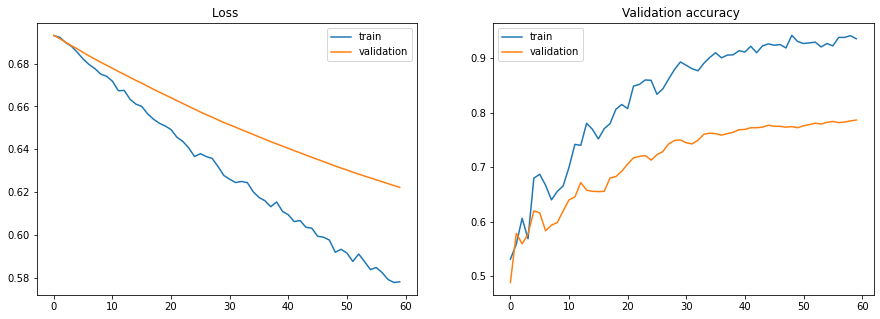

In [14]:
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=3000)

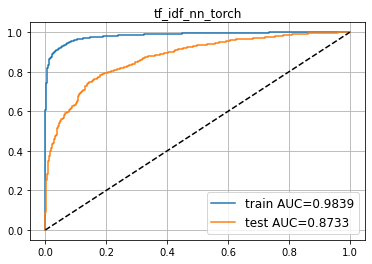

In [15]:
out_dict = visualize_and_save_results(model_tf_idf, 'tf_idf_nn_torch', X_train_tfidf_torch, X_test_tfidf_torch, y_train, y_test, out_dict)